In [1]:
from pathlib import Path
import os
import yaml
import pandas as pd
import numpy as np

from utils.helpers import flatten_dict

import seaborn as sns
import matplotlib.pyplot as plt
import string

from utils.helpers import flatten_dict, set_rcParams
import matplotlib.transforms as transforms



In [33]:
def load_hierarchical_experiment_results(exp_dir, split="test", exclude_strings=["task", "archive", "debug"]):

    # TODO keep path prefixes (e.g. eyepacs/eyepacs_gender/c2st/hash/version_x)

    # TODO save the following variables
    # - date of experiment
    # - subset attribute

    config_dicts = []
    result_dfs = []

    # get all experiments from subfolders
    for path in Path(exp_dir).rglob(f"{split}_consistency_analysis.csv"):
        path_parts = path.parts

        if not set(path_parts).isdisjoint(exclude_strings):
            continue

        version = path_parts[-2]
        exp_hash = path_parts[-3]
        method = path_parts[-4]

        config_file = os.path.join('/' + '/'.join(path_parts[1:-2]), "config.yaml")

        # open config
        with open(config_file) as fhandle:
            params = yaml.safe_load(fhandle)

        params = flatten_dict(params, sep="_")
        result = pd.read_csv(path)
        
        params["exp_hash"] = exp_hash
        result["exp_hash"] = exp_hash
        result["version"] = version
        result["method"] = method
        result["path"] = str(path.parent)
        
        config_dicts.append(params)
        result_dfs.append(result)
        
    configs = pd.DataFrame(config_dicts)
    configs = configs.set_index("exp_hash")
        
    results = pd.concat(result_dfs)
    results = results.set_index(["exp_hash", "sample_size"], drop=False)
    
    # keep latest version only!
    configs = configs[~configs.index.duplicated(keep="last")]
    results = results[~results.index.duplicated(keep="last")]

    
    df = configs.join(results)        
        
    return df




In [2]:
def add_letters(fig, axs, dx=-35/72., dy=15/72.):
    
    letterkwargs = dict(size=8, weight='bold', va='top', ha='left')

    offset = transforms.ScaledTranslation(
            dx, dy, fig.dpi_scale_trans)

    for idx, ax in enumerate(axs.flat):
        axs.flat[idx].text(0, 1, string.ascii_lowercase[idx], transform=axs.flat[idx].transAxes + offset, 
                    **letterkwargs)

    # for idx in range(len(ax)):
        # ax[idx].text(0, 1, string.ascii_lowercase[idx], transform=ax[idx].transAxes + offset, 
        #             **letterkwargs)


In [3]:
def style_powerplot(ax, y_ticks=[0, 0.25, 0.5, 0.75, 1], xlim=[0, 510], ylim=[0, 1.05], xlabel="Sample size"):

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    ax.grid(False)
    # ax[idx].set(xscale="log")
    # ax.set_ylabel("Power", )
    ax.set_ylabel("Shift detection rate", )
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, )
    

In [4]:
powerplot_height = 1.5
y_tick_type1err = [0, 0.02, 0.04, 0.06, 0.08]

# MMD ablation

- Data augmentation yes/no
- Architecture backbon Liu (original) / Resnet50

/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 1.0, 'MMD ablation')

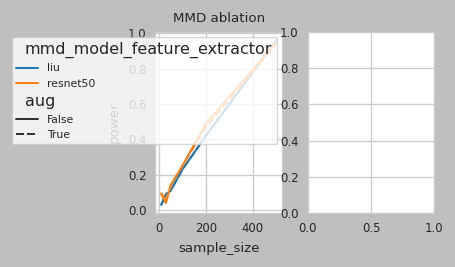

In [222]:
# exclude: mmd ablation experiments
mmdd = mmdd[mmdd['path'].str.contains("mmd_ablation")]

mmdd.shape

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]

x = df[df['path'].str.contains("mmd_ablation")]

x.shape

# x['aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
x.loc[x.index.tolist(), 'aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
# x['aug'] = x['aug'] * 1

# # 'dataset_ds_data_augmentation', 'mmd_model_feature_extractor',

set_rcParams()

fig, ax = plt.subplots(1,2, figsize=(3,2))

idx=0
sns.lineplot(data=x, x='sample_size', y='power', hue='mmd_model_feature_extractor', ax=ax[0], style="aug")
ax[idx].set_title("MMD ablation")

# txtkwargs = dict(size=8, weight='bold', va='top', ha='left')
# ax[idx].set(xscale="log")

 




In [223]:
# y = x["dataset_ds_data_augmentation"].iloc[0]

# x['aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
# x['aug'] = x["dataset_ds_data_augmentation"].apply(lambda row: row.len > 0, axis=1)
# x["dataset_ds_data_augmentation"].apply(len) > 0


x[['power', 'aug', 'mmd_model_feature_extractor']]
# len(y)


power    aug  \
exp_hash                         sample_size                 
72046db431aa631aa2e65d31b58cd269 10            0.03   True   
                                 30            0.09   True   
                                 50            0.11   True   
                                 100           0.23   True   
                                 200           0.42   True   
                                 500           0.96   True   
790524599b4484f4000d80befe4c5853 10            0.10   True   
                                 30            0.05   True   
                                 50            0.14   True   
                                 100           0.25   True   
                                 200           0.47   True   
                                 500           0.94   True   
803f18a148590c2d925eb90a784ff259 10            0.03  False   
                                 30            0.09  False   
                                 50            0.11  False   
                                 100           0.23  False   
                                 200           0.42  False   
                                 500           0.96  False   
c8ebfac3829cf454cd2c84d50a011199 10            0.09  False   
                                 30            0.04  False   
                                 50            0.14  False   
                                 100           0.25  False   
                                 200           0.49  False   
                                 500           0.95  False   

                                             mmd_model_feature_extractor  
exp_hash                         sample_size                              
72046db431aa631aa2e65d31b58cd269 10                                  liu  
                                 30                                  liu  
                                 50                                  liu  
                                 100                                 liu  
                                 200                                 liu  
                                 500                                 liu  
790524599b4484f4000d80befe4c5853 10                             resnet50  
                                 30                             resnet50  
                                 50                             resnet50  
                                 100                            resnet50  
                                 200                            resnet50  
                                 500                            resnet50  
803f18a148590c2d925eb90a784ff259 10                                  liu  
                                 30                                  liu  
                                 50                                  liu  
                                 100                                 liu  
                                 200                                 liu  
                                 500                                 liu  
c8ebfac3829cf454cd2c84d50a011199 10                             resnet50  
                                 30                             resnet50  
                                 50                             resnet50  
                                 100                            resnet50  
                                 200                            resnet50  
                                 500                            resnet50

# Influence of gradual overrepresentation of low quality

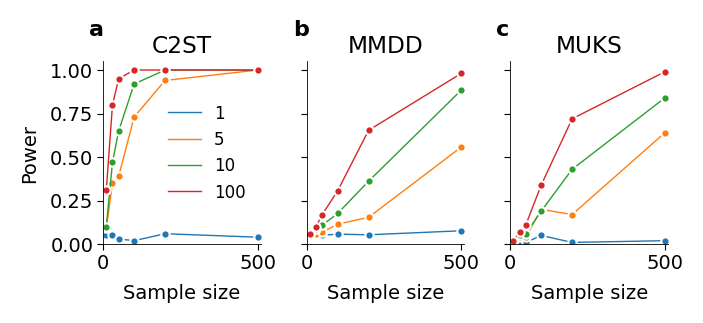

In [27]:
df = pd.read_csv('all_results.csv')

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]


df = df[df['path'].str.contains("eyepacs_quality_gradual")]


# df['shift_strength'] = df['dataset_dl_q_sampling_weights'][1]
# df['shift_strength'] = np.array(df['dataset_dl_q_sampling_weights'].tolist())[:,1]

def str_to_list(in_string):
    l_x = [i.strip() for i in in_string[1:-1].split(',')]
    return l_x

w = df['dataset_dl_q_sampling_weights'].apply(str_to_list)
df['shift_strength'] = np.array(w.tolist())[:,1]


hue_order = ['1', '5', '10', '100']

with plt.style.context("../utils/plot_style.txt"):

    num_plots = 3
    fig, ax = plt.subplots(1,num_plots, figsize=(3.4,powerplot_height), 
                        #    gridspec_kw={'width_ratios': [2, 2, 2, 1]},
                        layout="constrained",
                        sharey=True,
                        )



    idx=0
    sns.lineplot(data=df[df['method']=='c2st'], x='sample_size', y='power', hue='shift_strength', 
                 hue_order=hue_order,
                 ax=ax[idx], 
                 marker='.'
                 )
    ax[idx].set_title('C2ST')
    
    style_powerplot(ax[idx])

    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles=handles, labels=labels)
    ax[idx].get_legend().get_frame().set_linewidth(0.0)
    
    
    idx=1
    sns.lineplot(data=df[df['method']=='mmdd'], x='sample_size', y='power', hue='shift_strength',
                 hue_order=hue_order,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MMDD')
    
    style_powerplot(ax[idx])
    
    ax[idx].get_legend().remove()

    
    idx=2
    sns.lineplot(data=df[df['method']=='muks'], x='sample_size', y='power', hue='shift_strength', 
                                  hue_order=hue_order,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MUKS')

    style_powerplot(ax[idx])

    ax[idx].get_legend().remove()

    add_letters(fig, ax, dx=-5/72.)

    fig.savefig('eyepacs_gradual.pdf')


## Same, but with n_train = 1000

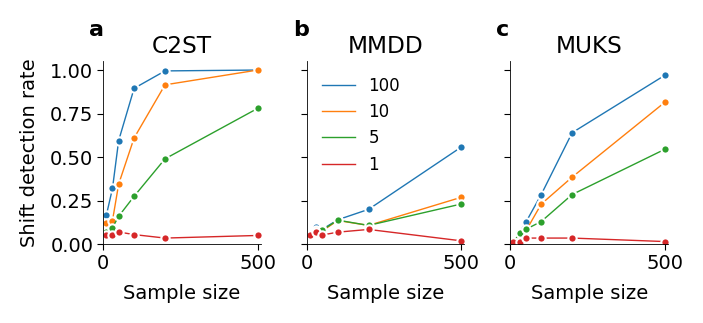

In [5]:
df = pd.read_csv('all_results_dh.csv')


df = df[df['path'].str.contains("/gradual/")]
df = df[df['path'].str.contains("/eyepacs_quality/")]


# df['shift_strength'] = df['dataset_dl_q_sampling_weights'][1]
# df['shift_strength'] = np.array(df['dataset_dl_q_sampling_weights'].tolist())[:,1]

def str_to_list(in_string):
    l_x = [i.strip() for i in in_string[1:-1].split(',')]
    return l_x

w = df['dataset_dl_q_sampling_weights'].apply(str_to_list)
df['shift_strength'] = np.array(w.tolist())[:,1]

hue_order = ['100', '10', '5', '1', ]

with plt.style.context("../utils/plot_style.txt"):

    num_plots = 3
    fig, ax = plt.subplots(1,num_plots, figsize=(3.4,powerplot_height), 
                        #    gridspec_kw={'width_ratios': [2, 2, 2, 1]},
                        layout="constrained",
                        sharey=True,
                        )



    idx=0
    sns.lineplot(data=df[df['method']=='c2st'], x='sample_size', y='power', hue='shift_strength', 
                 hue_order=hue_order,
                    ci=None,
                 ax=ax[idx], 
                 marker='.'
                 )
    ax[idx].set_title('C2ST')
    
    style_powerplot(ax[idx])
    
    ax[idx].get_legend().remove()
    
    idx=1
    sns.lineplot(data=df[df['method']=='mmdd'], x='sample_size', y='power', hue='shift_strength',
                 hue_order=hue_order,
                ci=None,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MMDD')
    
    style_powerplot(ax[idx])
    
    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles=handles, labels=labels)
    ax[idx].get_legend().get_frame().set_linewidth(0.0)
    
    idx=2
    sns.lineplot(data=df[df['method']=='muks'], x='sample_size', y='power', hue='shift_strength', 
                                  hue_order=hue_order,
                ci=None,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MUKS')

    style_powerplot(ax[idx])

    ax[idx].get_legend().remove()

    add_letters(fig, ax, dx=-5/72.)

    fig.savefig('./figs/eyepacs_gradual.pdf')

# Limited training set size (absolute numbers)

In [38]:
exp_dir = "/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs_seeded_trainset_limited_debug"

df = load_hierarchical_experiment_results(exp_dir, exclude_strings=["task", "archive"])

print(df.shape)


(2106, 93)


In [39]:

df.to_csv('all_results_dh.csv')



In [5]:

df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]



quality = df[df['path'].str.contains("/eyepacs_quality/")]
ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]
sex = df[df['path'].str.contains("/eyepacs_sex/")]
comorbids = df[df['path'].str.contains("/eyepacs_comorb/")]
quality_OOD = df[df['path'].str.contains("/eyepacs_quality_OOD/")]

# keep Latin American and Caucasian only

# ethnicity = ethnicity.dropna(subset=["dataset_ds_q_subset_params_patient_ethnicity"])

# # function that checks whether the integer 1 is in the list
# def contains_main_groups(lst):
#     # return "Caucasian" in lst
#     # return "African Descent" in lst
#     return "African Descent" in lst or "Caucasian" in lst
#     # return "Latin American" in lst or "Caucasian" in lst
#     # return "Asian" in lst

# ethnicity = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups)]


print(df.shape)
print(quality.shape)
print(ethnicity.shape)



(1836, 96)
(216, 96)
(936, 96)


In [6]:
df['path']

120     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
121     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
122     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
123     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
124     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
                              ...                        
1951    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1952    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1953    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1954    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1955    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
Name: path, Length: 1836, dtype: object

In [252]:
ethnicity[(ethnicity['method'] == 'c2st') & (ethnicity['sample_size'] == 100)][['dataset_ds_data_size_abs', 'power', 'dataset_ds_q_subset_params_patient_ethnicity']].sort_values(by='dataset_ds_data_size_abs')

,,dataset_ds_data_size_abs,power,dataset_ds_q_subset_params_patient_ethnicity
exp_hash,sample_size,,,
c257baf20fd3d784dd11e44caf301521,100,100,1.00,[Caucasian]
236f1f40303e2ed924340d7b0f9762b8,100,100,1.00,[Caucasian]
ad049883f29a494072f115033d904058,100,100,0.59,[African Descent]
6adafc243fa5aba3a6129b8692544c41,100,100,0.11,[African Descent]
ded60609c4497503fa21a18eb2ae66ed,100,500,1.00,[Caucasian]
bc4a7609827ac14e9b4d42ea633f0f4c,100,500,0.94,[African Descent]
59424da3ea9d2a761d261bc3b466b30c,100,500,1.00,[African Descent]
7e11b4515b76d6c237d5f358519ada95,100,500,1.00,[Caucasian]
1840b4ebb850d4811efb6235a272fa2f,100,1000,1.00,[Caucasian]


# Fig. 2: Results summary (ethnicity separate)

2 rows:
row 1: x - train size - y: power at test size 500
row 2: x - test size - y: power at some train size (indicated in row 1)


- Fig 1: 1. Co-morbidities, 2. sex, 3. quality (subgroup), 4. quality (OOD), 5. type I err 


- Fig 2: Ethnicity: Latin, Caucasian, African, Asian, Indian



In [40]:
# check for quality at dataset_ds_data_size_abs = 1000

df = pd.read_csv('all_results_dh.csv')

# df = df[df['dataset_ds_data_size_abs'] == 1000]
df = df[df['sample_size'] == 500]

df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]

df = df[df['path'].str.contains("/eyepacs_quality/")]

df.shape

# df[df['exp_hash'] == '70fd2858a08dd666b5786ecd1ebf707e']['path'].values

(36, 95)

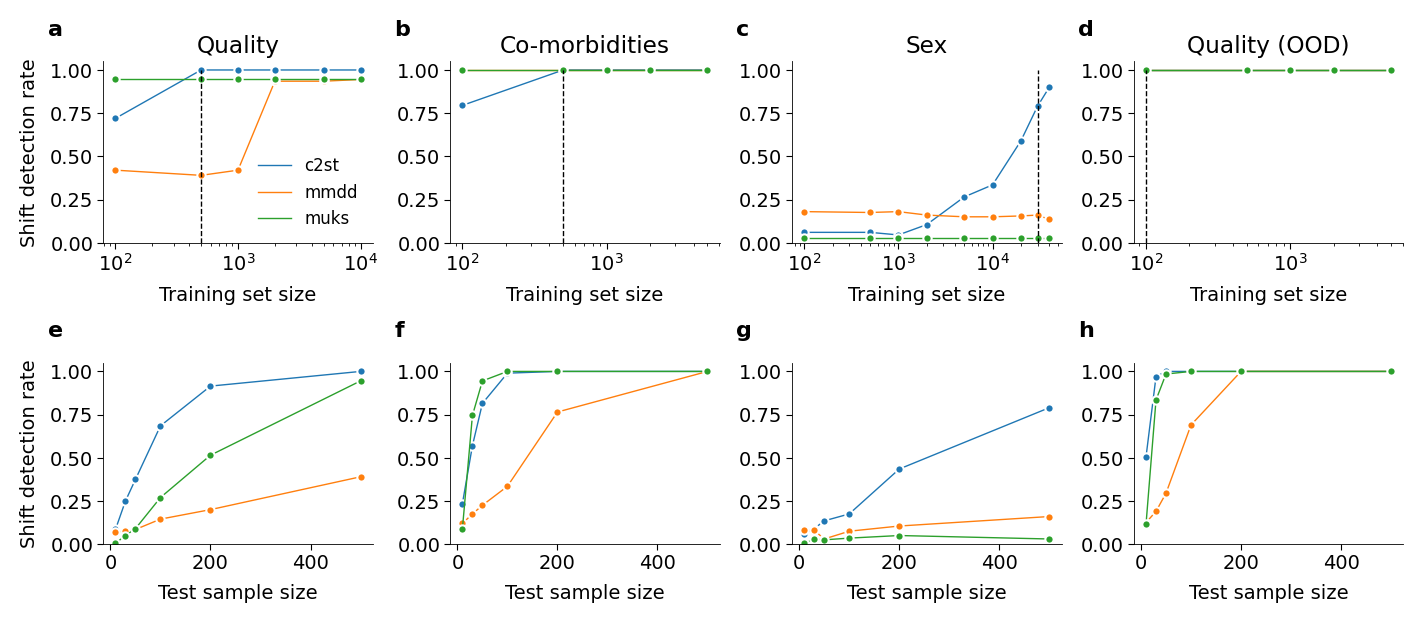

In [6]:

df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]



quality = df[df['path'].str.contains("/eyepacs_quality/")]
ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]
sex = df[df['path'].str.contains("/eyepacs_sex/")]
comorbids = df[df['path'].str.contains("/eyepacs_comorb/")]
quality_OOD = df[df['path'].str.contains("/eyepacs_quality_OOD/")]


methods = ['c2st', 'mmdd', 'muks']
n_train = [100, 500, 1000, 2000, 5000, 10000]

ssize = 500



with plt.style.context("../utils/plot_style.txt"):

    num_plots = 4
    fig, ax = plt.subplots(2, num_plots, figsize=(7, 3), 
                           gridspec_kw={'width_ratios': [2, 2, 2, 2]},
                        layout="constrained",
                        )


    row = 0

    x_label_top = "Training set size"
    x_label_bottom = "Test sample size"

    idx=0
    sns.lineplot(data=quality[quality['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("Quality")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    handles, labels = ax[row, idx].get_legend_handles_labels()
    ax[row, idx].legend(handles=handles, labels=labels, loc='lower right')
    ax[row, idx].get_legend().get_frame().set_linewidth(0.0)
    # ax[idx].get_legend().remove()
    ax[row, idx].set_xscale('log')


    # single vline with specific ymin and ymax
    
    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=quality[quality['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)


    idx=1
    sns.lineplot(data=comorbids[comorbids['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("Co-morbidities")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)


    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()
    ax[row, idx].set_xscale('log')

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=comorbids[comorbids['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[row, idx].set_xscale('log')

    idx=2
    sns.lineplot(data=sex[sex['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("Sex")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()
    ax[row, idx].set_xscale('log')

    test_size = 30000
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=sex[sex['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()


    idx=3
    sns.lineplot(data=quality_OOD[quality_OOD['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("Quality (OOD)")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()
    ax[row, idx].set_xscale('log')

    test_size = 100
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')

    sns.lineplot(data=quality_OOD[quality_OOD['dataset_ds_data_size_abs'] == 100], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()


    # idx=4

    # bp = sns.pointplot(data=df, x="method", y="type_1err", join=False,  ax=ax[row, idx], palette=sns.color_palette())

    # bp.set(xticklabels=[])
    # bp.set(xlabel=None)

    # ax[row, idx].set_ylim([0, 0.08])
    # ax[row, idx].set_ylabel("Type I error")
    # ax[row, idx].set_yticks(y_tick_type1err, )

    # ax[row, idx].spines['bottom'].set_visible(False)
    # ax[row, idx].set_xticks([])



    # ax[1, idx].remove()


    add_letters(fig, ax, dx=-20/72.)

    fig.savefig('figs/eyepacs_qual_comorbid_sex_ood.pdf')

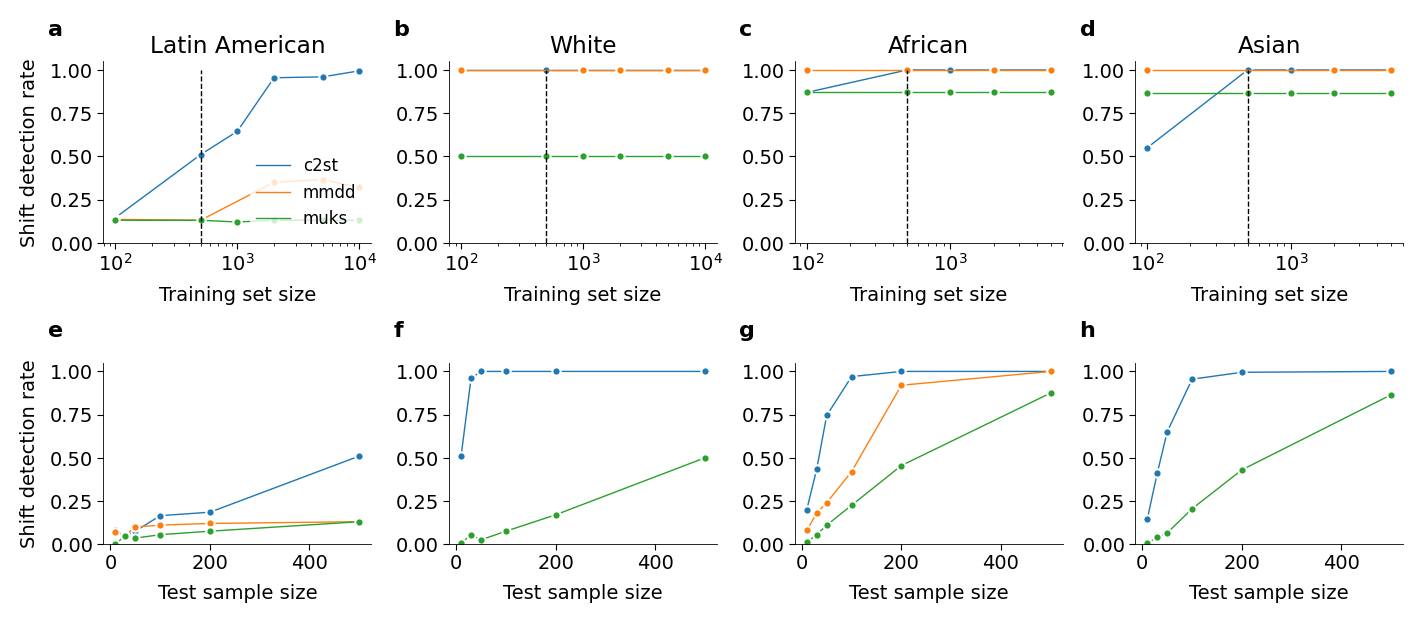

In [7]:
methods = ['c2st', 'mmdd', 'muks']
n_train = [100, 500, 1000, 2000, 5000, 10000]
# n_train = [100, 500, 1000, 2000]

ssize = 500

ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]

# keep Latin American and Caucasian only

ethnicity = ethnicity.dropna(subset=["dataset_ds_q_subset_params_patient_ethnicity"])

# function that checks whether the integer 1 is in the list
def contains_main_groups(lst, group="African Descent"):
    return group in lst


latin_american = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Latin American",))]
caucasian = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Caucasian",))]
african = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("African Descent",))]
asian = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Asian",))]
indian = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Indian subcontinent origin",))]
multiracial = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Multi-racial",))]
native = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Native American",))]



with plt.style.context("../utils/plot_style.txt"):

    num_plots = 4
    fig, ax = plt.subplots(2, num_plots, figsize=(7, 3), 
                           gridspec_kw={'width_ratios': [2, 2, 2, 2]},
                        layout="constrained",
                        )


    row = 0

    x_label_top = "Training set size"
    x_label_bottom = "Test sample size"

    idx=0
    sns.lineplot(data=latin_american[latin_american['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("Latin American")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    handles, labels = ax[row, idx].get_legend_handles_labels()
    ax[row, idx].legend(handles=handles, labels=labels, loc='lower right')
    ax[row, idx].get_legend().get_frame().set_linewidth(0.0)
    # ax[idx].get_legend().remove()
    ax[row, idx].set_xscale('log')


    # single vline with specific ymin and ymax
    
    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=latin_american[latin_american['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[1, idx], marker='.')
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)


    idx=1
    sns.lineplot(data=caucasian[caucasian['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("White")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)


    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')
    ax[row, idx].set_xscale('log')


    sns.lineplot(data=caucasian[caucasian['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)

    idx=2
    sns.lineplot(data=african[african['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("African")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')
    ax[row, idx].set_xscale('log')


    sns.lineplot(data=african[african['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()


    idx=3
    sns.lineplot(data=asian[asian['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("Asian")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')
    ax[row, idx].set_xscale('log')

    sns.lineplot(data=asian[asian['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()

    # add_letters(fig, ax)

    # idx=4

    # bp = sns.pointplot(data=ethnicity, x="method", y="type_1err", join=False,  ax=ax[row, idx], palette=sns.color_palette())

    # bp.set(xticklabels=[])
    # bp.set(xlabel=None)

    # ax[row, idx].set_ylim([0, 0.08])
    # ax[row, idx].set_ylabel("Type I error")
    # ax[row, idx].set_yticks(y_tick_type1err, )

    # ax[row, idx].spines['bottom'].set_visible(False)
    # ax[row, idx].set_xticks([])



    # ax[1, idx].remove()

    add_letters(fig, ax, dx=-20/72.)

    fig.savefig('figs/eyepacs_ethnicity.pdf')

# Ablations

- img resolution at n_train = 1000

C2ST-512, C2ST-96, MMDD-96



In [33]:
df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


# df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]


df = df[df['dataset_ds_data_size_abs'] == 1000]


quality = df[df['path'].str.contains("/eyepacs_quality/")]
ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]
sex = df[df['path'].str.contains("/eyepacs_sex/")]
comorbids = df[df['path'].str.contains("/eyepacs_comorb/")]
quality_OOD = df[df['path'].str.contains("/eyepacs_quality_OOD/")]

quality['attribute'] = "Quality"
quality_OOD['attribute'] = "Quality (OOD)"
comorbids['attribute'] = "Co-morbidities"
ethnicity['attribute'] = "Ethnicity"
sex['attribute'] = "Sex"

# TODO: include c2st96, evaluate at n_train = 1000



table_results = pd.concat([quality, comorbids, ethnicity, sex, quality_OOD])
# table_results = table_results[['method', 'attribute', 'sample_size', 'power', 'dataset_ds_basic_preproc_img_size']]

table_results
table_results = table_results.groupby(["sample_size", "method", "dataset_ds_basic_preproc_img_size", "attribute"])['power'].mean().reset_index()


table_rows = []

title_row_1 = "Shift & Test & 10 & 30 & 50 & 100 & 200 & 500 \n"
table_rows.append(title_row_1)

table_rows.append("\hline \n")

for shift_type in table_results['attribute'].unique():
    print(shift_type)

    c2st512 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 512)  & (table_results['method'] == "c2st")]
    c2st96 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 96)  & (table_results['method'] == "c2st")]
    mmdd = table_results[(table_results['attribute'] == shift_type) & (table_results['method'] == "mmdd")]

    row = f"{shift_type} & C2ST-512 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st512['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & C2ST-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st96['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & MMDD-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(mmdd['power'])]) + "\\\\  \n"
    table_rows.append(row)

    table_rows.append("\hline \n")


table_file = "size_ablation_table.txt"
with open(table_file, "w") as f:
    f.writelines(table_rows)


Co-morbidities
Ethnicity
Quality
Sex
Quality (OOD)


/tmp/ipykernel_18355/1488247236.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality['attribute'] = "Quality"
/tmp/ipykernel_18355/1488247236.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_OOD['attribute'] = "Quality (OOD)"
/tmp/ipykernel_18355/1488247236.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [88]:
df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
# df = df[df['path'].str.contains("c2st_arch") == False]


df = df[df['dataset_ds_data_size_abs'] == 1000]
df = df[df['method'] == 'c2st']


df = df[df['path'].str.contains("/eyepacs_quality/")]

# quality['attribute'] = "Quality"


df['attribute'] = df['domain_classifier_model_arch']

# df = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])


df['attribute']
df.shape

# TODO where are the shallows?

table_results = df
# table_results = table_results[['method', 'attribute', 'sample_size', 'power', 'dataset_ds_basic_preproc_img_size']]

table_results
table_results = table_results.groupby(["sample_size", "method", "attribute"])['power'].mean().reset_index()

table_results

,sample_size,method,attribute,power
0,10,c2st,resnet18,0.085
1,10,c2st,resnet50,0.135
2,10,c2st,shallow,0.035
3,30,c2st,resnet18,0.200
4,30,c2st,resnet50,0.290
5,30,c2st,shallow,0.075
6,50,c2st,resnet18,0.405
7,50,c2st,resnet50,0.465
8,50,c2st,shallow,0.080
9,100,c2st,resnet18,0.745


In [89]:


table_rows = []

title_row_1 = "Architecture & 10 & 30 & 50 & 100 & 200 & 500 \n"
table_rows.append(title_row_1)

table_rows.append("\hline \n")

for shift_type in table_results['attribute'].unique():
    print(shift_type)

    row_vals = table_results[table_results['attribute'] == shift_type]

    row = f"{shift_type}  & " + ' & '.join([f"{ele:.02f}" for ele in list(row_vals['power'])]) + "\\\\  \n"
    table_rows.append(row)

    table_rows.append("\hline \n")


table_file = "arch_ablation_table.txt"
with open(table_file, "w") as f:
    f.writelines(table_rows)


resnet18
resnet50
shallow
